## Chaung


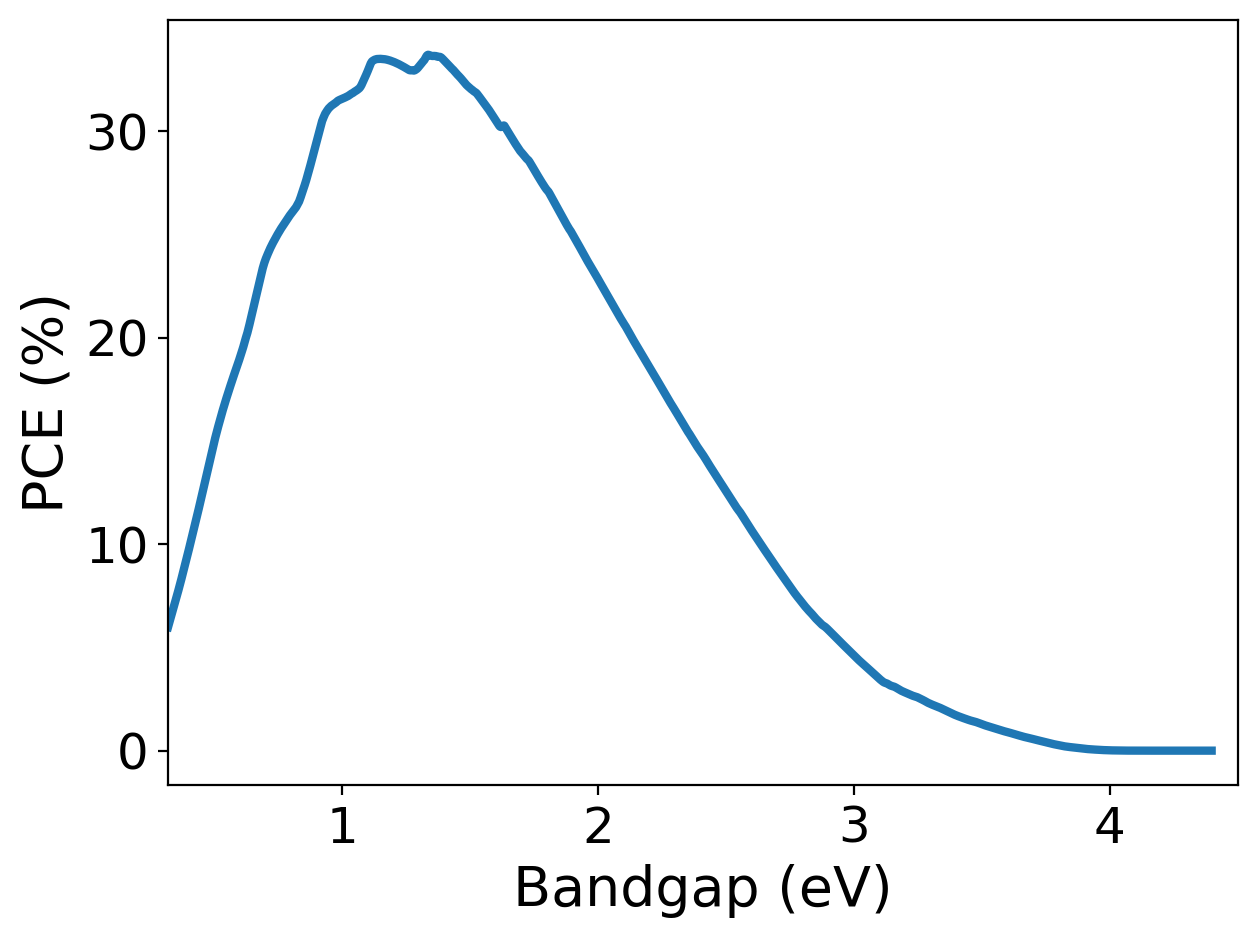

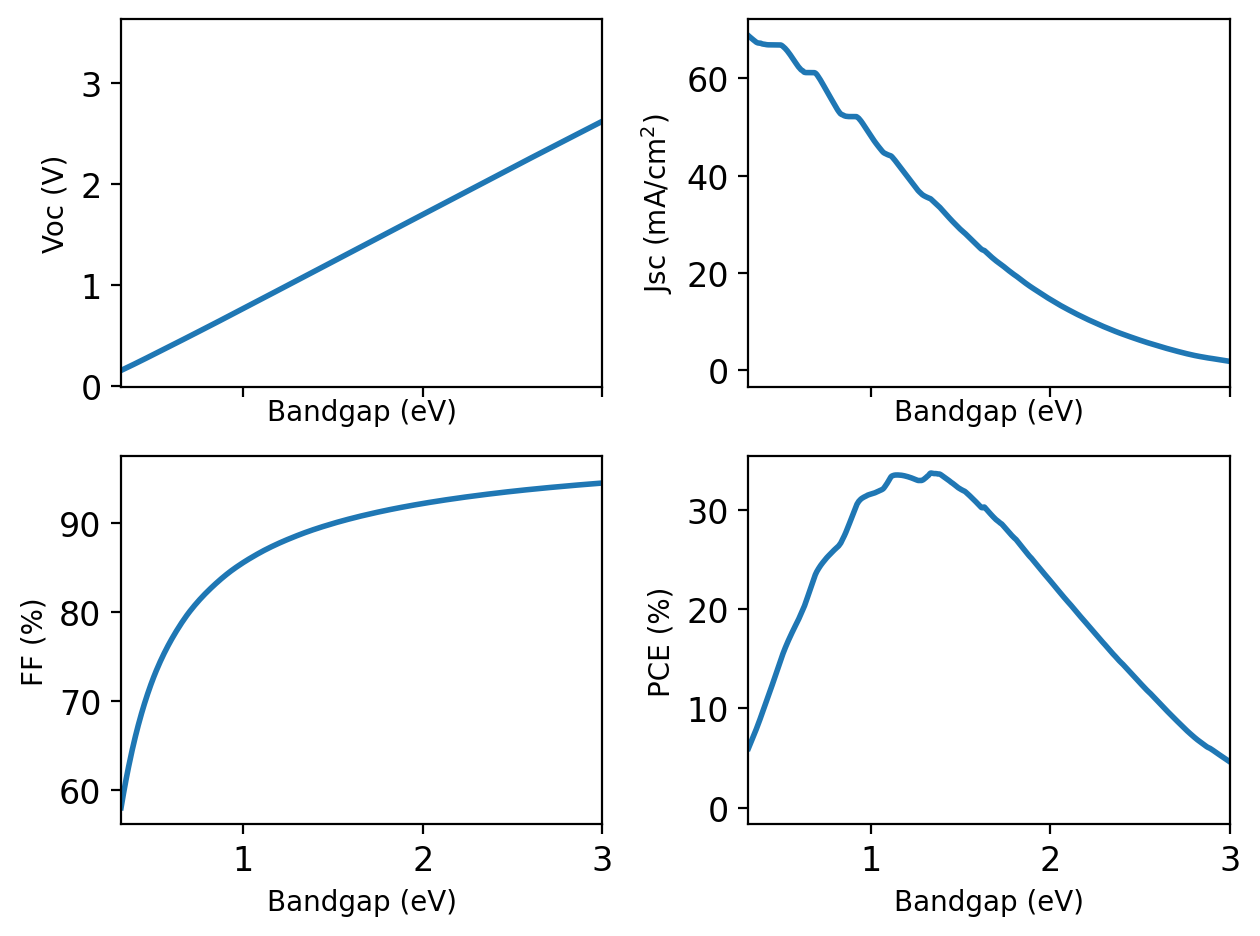

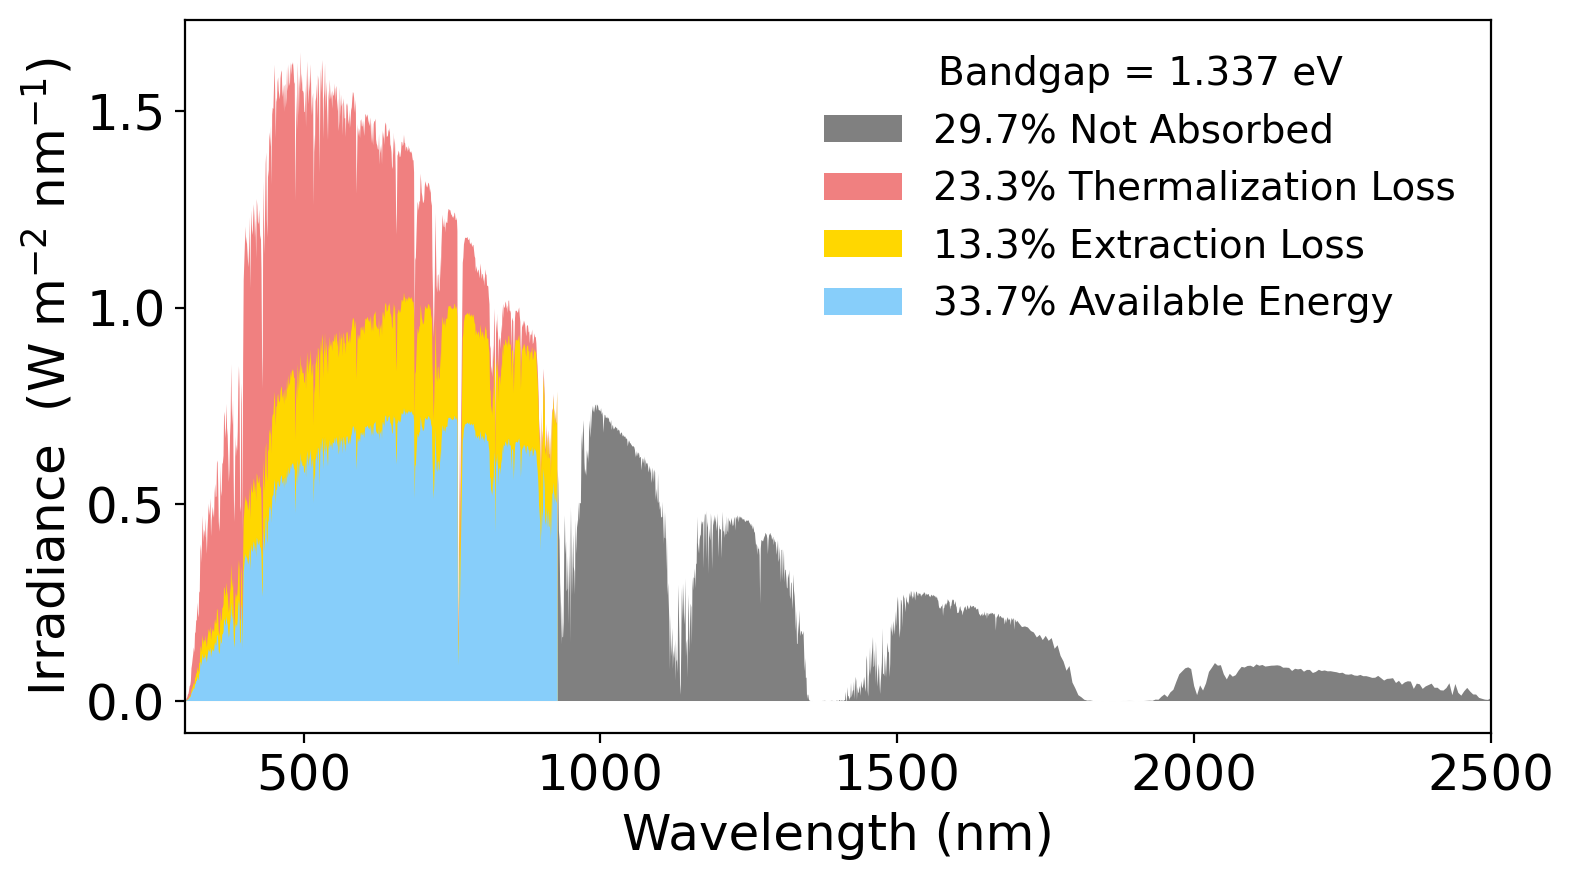

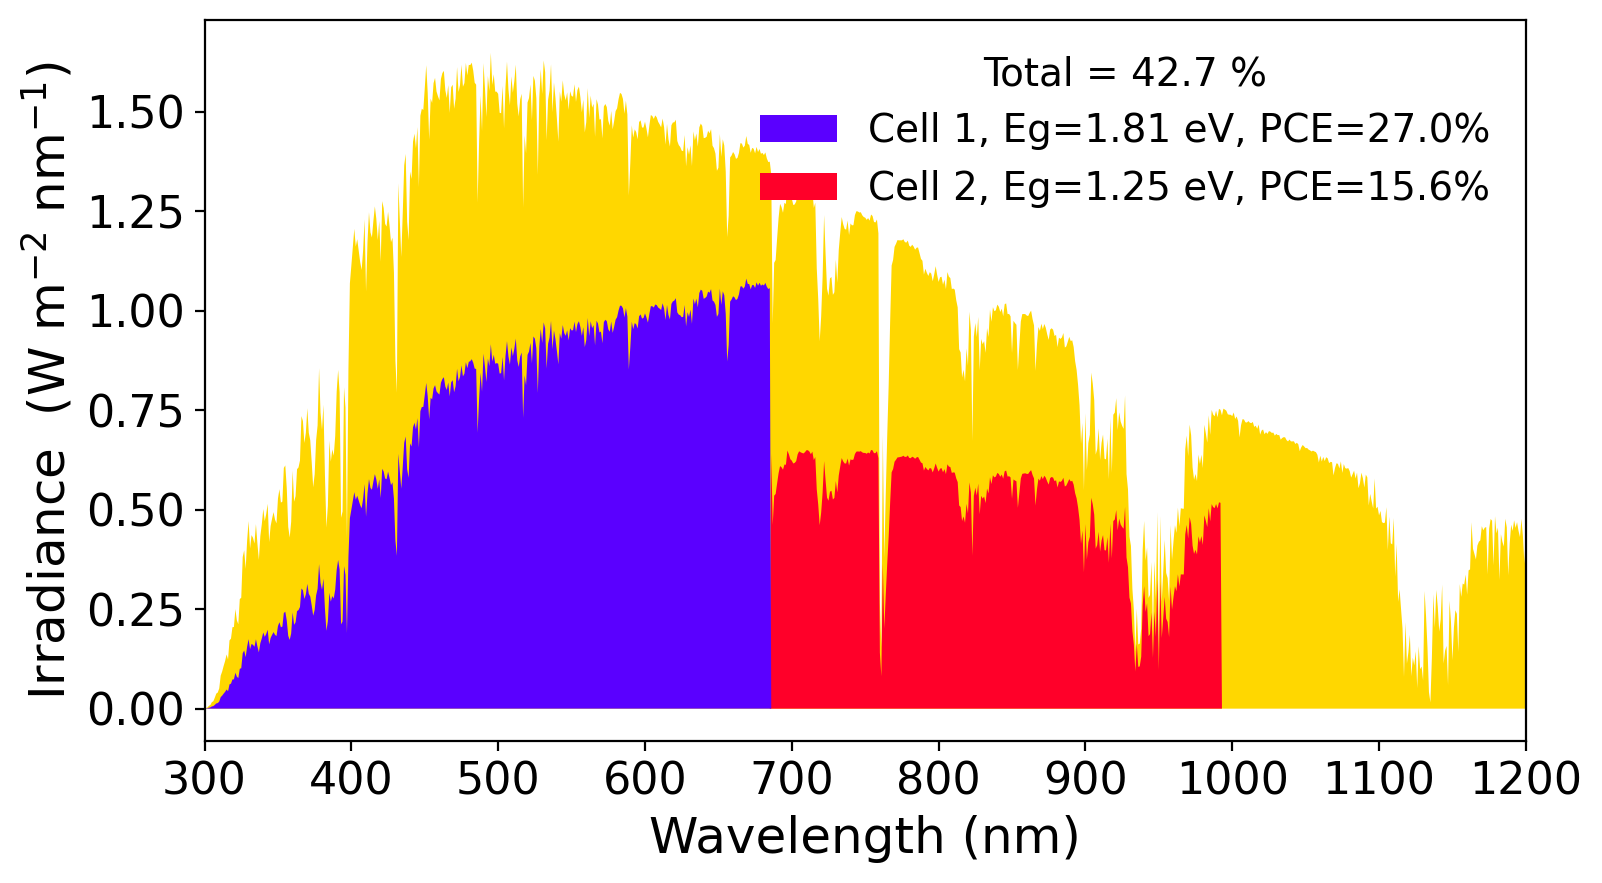

In [17]:
# -*- coding: utf-8 -*-
"""
@author: C. Marcus Chuang 2016
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.cm as pltcm
from scipy.integrate import cumtrapz
try:  # use seaborn to choose better colors
    import seaborn.apionly as sns
    with_sns = True
except:  # if you don't have seaborn
    with_sns = False
# plt.style.use(['ggplot','dark_background'])
plt.ion()

from matplotlib import style
%config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)

k = 1.38064852e-23  # m^2 kg s^-2 K^-1, Boltzman constant
h = 6.62607004e-34   # m^2 kg s^-1    , planck constant
c = 2.99792458e8     # m s^-1         , speed of light
eV = 1.6021766208e-19  # joule        , eV to joule
q = 1.6021766208e-19  # C             , elemental charge

# http://rredc.nrel.gov/solar/spectra/am1.5/
ref_solar = pd.read_csv('/Users/deniz/Documents/GitHub/Shockley-Queisser-limit/ASTMG173.csv', header=1)  # nm vs W m^-2 nm^-1
# data range: 280nm to 4000nm, 0.31eV to 4.42857 eV
# WL (nm), W*m-2*nm-1
WL, solar_per_nm = ref_solar.iloc[:, 0], ref_solar.iloc[:, 2]
E = 1240.0 / WL  # eV
# jacobian transformation, W m^-2 eV^-1
solar_per_E = solar_per_nm * (eV/1e-9) * h * c / (eV*E)**2

Es = np.arange(0.32, 4.401, 0.002)

# linear interpolation to get an equally spaced spectrum
AM15 = np.interp(Es, E[::-1], solar_per_E[::-1])  # W m^-2 eV^-1
AM15flux = AM15 / (Es*eV)  # number of photon m^-2 eV^-1 s^-1




class SQlim(object):
    def __init__(self, T=300, EQE_EL=1.0, intensity=1.0):


        """
        T: temperature in K
        EQE_EL: radiative efficiency (EL quantum yield)
        intensity: light concentration, 1.0 = one Sun, 100 mW/cm^2
        """
        try:
            T, EQE_EL, intensity = float(T), float(EQE_EL), float(intensity)
        except:
            raise ValueError("Invalid input for T, EQE_EL, or intensity")

        if T <= 0 or EQE_EL > 1.0 or EQE_EL <= 0:
            raise ValueError("Both T and EQE_EL must be greater than 0 and " +
                             "EQE_EL cannot be greater than 1.0")
        self.T = T
        self.EQE_EL = EQE_EL
        self.intensity = intensity
        self.Es = Es  # np.arange(0.32, 4.401, 0.002)
        self.calculate()
        self.WLs = np.arange(280, 4001, 1.0)
        self.AM15nm = np.interp(self.WLs, WL, solar_per_nm)

    def __repr__(self):
        s = "<SQlim:"
        conditions = []
        if self.T != 300.0:
            conditions.append("T={:.0f}K".format(self.T))
        if self.intensity != 1.0:
            conditions.append("{:.4g}-Sun".format(self.intensity))
        if self.EQE_EL != 1.0:
            conditions.append("EQE_EL={:.2E}".format(self.EQE_EL))

        if conditions:
            return s + " [" + ", ".join(conditions) + "]" + ">"
        return s + " [standard]>"

    def calculate(self):
        self.J0 = self.__cal_E_J0()  # dark saturation current density
        self.Jsc = self.__cal_E_Jsc()  # shor-circuit current density
        self.Voc = self.__cal_E_Voc()  # open circuit voltage
        self.PCE = self.__cal_E_PCE()  # power conversion efficiency
        # flll factor (%)
        self.FF = self.PCE / (self.Voc*self.Jsc) * 100.0 * self.intensity
        self.paras = {"Voc": self.Voc, "Jsc": self.Jsc, "J0": self.J0,
                      "FF": self.FF, "PCE": self.PCE}
        return None

    def __cal_E_Jsc(self):
        fluxcumm = cumtrapz(AM15flux[::-1], self.Es[::-1], initial=0)
        fluxaboveE = fluxcumm[::-1] * -1 * self.intensity
        Jsc = fluxaboveE * q * 0.1  # mA/cm^2  (0.1: from A/m2 to mA/cm2)
        return Jsc

    def __cal_E_J0(self):
        '''
        Calculate and return E vs J0, the dark saturation current
        J0 = q * (integrate(phi dE) from E to infinity)  / EQE_EL
        phi is the black body radiation at T (flux vs energy)

        '''
        phi = 2 * np.pi * (((self.Es*eV)**2) * eV / ((h**3) * (c**2)) / (
                           np.exp(self.Es*eV / (k*self.T)) - 1))

        # fluxcumm = sp.integrate.cumtrapz(phi[::-1], self.Es[::-1], initial=0)
        fluxcumm = cumtrapz(phi[::-1], self.Es[::-1], initial=0)
        fluxaboveE = fluxcumm[::-1] * -1
        J0 = fluxaboveE * q * 0.1 / self.EQE_EL  # (0.1: from A/m2 to mA/cm2)
        J0[-1] = np.nan  # avoid divide by zero when calculating Voc
        return J0

    def __cal_E_Voc(self):
        '''
        Calculate and return E vs Voc
        Voc = (kT/q)*[ ln(Jsc/J0 + 1 )]
        '''
        return (k*self.T/q) * np.log((self.Jsc/self.J0) + 1)

    def __cal_E_PCE(self):
        PCE = []
        for i, E in enumerate(self.Es):
            V = np.arange(0, E, 0.001)  # can change upperbound to Voc
            J = -1 * self.Jsc[i] + self.J0[i] * (
                np.exp(q*V / (k*self.T)) - 1)
            PCE.append(-1 * np.min(J*V) / self.intensity)
        return PCE

    def simulate_JV(self, Eg, plot_dark=False, Vstep=0.001,
                    plot=True, Vmin=-0.5):
        """
        Simulate J-V curves for a solar cell at given Eg
        """

        if not self.Es[0] <= Eg <= self.Es[-1]:
            print ('invalid bandgap valid range: 0.32 to 4.4')
            return
        V = np.arange(Vmin, Eg, Vstep)
        paras = self.get_paras(Eg, toPrint=False)
        J0, Jsc = paras["J0"], paras["Jsc"]

        J = -1.0 * Jsc + J0 * (np.exp(q*V / (k*self.T)) - 1)
        if plot_dark:
            Jdark = J + Jsc
        mask = (J <= 200)
        if plot:
            # to do:
            # could modify the method to take xlim, ylim as inputs
            # move 'title' into the figure and add add Voc Jsc FF, PCE to it
            title = "Theoretical J-V for Eg = {:.3f} eV".format(Eg)
            # plt.figure()
            plt.plot(V[mask], J[mask], 'r')
            plt.plot([-1, Eg], [0, 0], 'k')
            plt.plot([0, 0], [-2 * Jsc, 200], 'k')
            if plot_dark:
                plt.plot(V[mask], Jdark[mask], 'b')
            plt.ylim(-1.5 * Jsc, min(40, 1.5 * Jsc))
            plt.xlim(-0.25, Eg)
            plt.xlabel("Voltage (V)", fontsize=16)
            plt.ylabel("Current density (mA/$\mathregular{cm^2}$)",
                       fontsize=16)
            plt.tick_params(labelsize=16)
            plt.title(title)
            plt.tight_layout()

        return np.vstack([V, J])  # col1: V, col2:J, photocurrent only

    def get_paras(self, Eg, toPrint=True):
        '''
        input Eg, return or print the corresponding parameters
        if toPrint == True : print the result, return nothing
        if toPrint == False: return the result as a dictionary
        '''

        if not self.Es[0] <= Eg <= self.Es[-1]:
            print ('invalid bandgap \nvalid range: 0.32 to 4.4')
            return
        para = {}
        # could change these to binary search
        para["Voc"] = np.interp([Eg], self.Es, self.Voc)[0]
        para["Jsc"] = np.interp([Eg], self.Es, self.Jsc)[0]
        para["FF"] = np.interp([Eg], self.Es, self.FF)[0]
        para["PCE"] = np.interp([Eg], self.Es, self.PCE)[0]
        para["J0"] = np.interp([Eg], self.Es, self.J0)[0]

        if toPrint:  # won't return anything; print in console instead
            print
            print ('Bandgap: {0:.3f} eV'.format(Eg))
            print ("J0 = {0:.3g} mA/cm^2".format(para["J0"]))
            print ("Voc = {0:.4g} \t V".format(para["Voc"]))
            print ("Jsc = {0:.4g} \t mA/cm^2".format(para["Jsc"]))
            print ("FF  = {0:.2f} \t %".format(para["FF"]))
            print ("PCE = {0:.3f} \t %".format(para["PCE"]))
            return

        return para

    def saveall(self, savename="SQ limit"):
        """
        save the data as a .csv file
        """
        result = pd.DataFrame()
        result["Bandgap (eV)"] = self.Es
        result["Voc (V)"] = self.Voc
        result["Jsc (mA/cm^2)"] = self.Jsc
        result["FF (%)"] = self.FF
        result["PCE (%)"] = self.PCE
        result["J0 (mA/cm^2)"] = self.J0
        result.to_csv(savename + ".csv", index=False)

        return result

    def plot(self, para="PCE", xlims=(0.32, 4.5)):
        """
        plot one parameters in a plot
        paras: "Voc", "Jsc", "FF", "PCE", or "J0"
        J0 will be plotted in a semi-log plot.
        """

        if para not in self.paras:
            print ("Invalid input! Valid inputs are:")
            print ('"Voc", "Jsc", "FF", "PCE", and "J0"')
            return
        yunits = {"Voc": "(V)", "Jsc": "(mA/$\mathregular{cm^2}$)",
                  "FF": "(%)", "J0": "(mA/$\mathregular{cm^2}$)",
                  "PCE": "(%)"}
        plt.figure(para)
        ax = plt.gca()
        ax.plot(self.Es, self.paras[para], lw=3)

        if para == "J0":
            ax.set_yscale('log')
        ax.set_ylabel(para + " " + yunits[para], size=20)
        ax.set_xlim(xlims)
        ax.set_xlabel("Bandgap (eV)", size=20)
        ax.tick_params(labelsize=18)
        plt.tight_layout()
        plt.show()

        return

    def plotall(self, xlims=(0.32, 3.0)):
        """
        plot Voc, Jsc, FF, and PCE in a figure with 4 subplots
        """

        fig, ax = plt.subplots(2, 2, sharex=True)  # figsize=(8, 8)
        axs = [(0, 0), (0, 1), (1, 0), (1, 1)]
        ys = [self.Voc, self.Jsc, self.FF, self.PCE]
        ylabel = ["Voc (V)", "Jsc (mA/$\mathregular{cm^2}$)", "FF (%)",
                  "PCE (%)"]
        for i, a in enumerate(axs):
            ax[axs[i]].plot(self.Es, ys[i], lw=2)
            ax[axs[i]].set_ylabel(ylabel[i])
            plt.setp(ax[axs[i]].get_xticklabels(), visible=True)
            ax[axs[i]].set_xlabel("Bandgap (eV)")
            ax[axs[i]].tick_params(labelsize=12)
        ax[(0, 0)].set_xlim(xlims)
        plt.tight_layout()
        plt.show()
        return

    def E_loss(self, Eg, xmin=300, xmax=2500, savefig=False):
        """
        input bandgap Eg, plot the energy loss and the available energy
        Eg :  bandgap (unit: eV)
        xmin, xmax: the limit for x-axis in the plot (unit: nm)

        return : a dictionary containing the energy losses

        """

        if Eg > 4.2 or Eg < 0.32:
            print ('invalid bandgap \nvalid range: 0.32 to 4.2')
            return None

        xmax = max(xmax, 1240.0 / Eg)

        # WLs = self.WLs
        # AM15nm = self.AM15nm

        plt.figure(figsize=(8, 4.5))
        ax = plt.gca()
        # color options: darkgoldenrod, darkorange, yellow, black
        colors = {'therm': 'lightcoral', 'extract': 'gold',
                  'avail': 'LightSkyBlue', 'trans': 'grey'}

        mask = (1240.0/self.WLs) >= Eg

        para = SQ.get_paras(Eg, toPrint=False)
        factor = para["Voc"] * para["FF"] / 100.0 / Eg
        extract = self.AM15nm / (1240.0/self.WLs) * Eg * mask
        Eavail = extract * factor
        therm = self.AM15nm * mask

        extractloss = extract - Eavail
        thermloss = therm - extract
        transloss = self.AM15nm * (1 - mask)

        ax.fill_between(self.WLs, 0, transloss,
                        linewidth=0, facecolor=colors['trans'])
        ax.fill_between(self.WLs, 0, therm,
                        linewidth=0, facecolor=colors['therm'])
        ax.fill_between(self.WLs, 0, extract,
                        linewidth=0, facecolor=colors['extract'])
        ax.fill_between(self.WLs, 0, Eavail,
                        linewidth=0, facecolor=colors['avail'])

        E_tot = np.sum(self.AM15nm)
        E_pct = {'trans': np.sum(transloss) / E_tot,
                 'therm': np.sum(thermloss) / E_tot,
                 'extract': np.sum(extractloss) / E_tot,
                 'avail': np.sum(Eavail) / E_tot}

        legendtitle = "Bandgap = {0:.3f} eV".format(Eg)
        legends = [plt.Rectangle((0, 0), 1, 1,
                   facecolor=colors[i], edgecolor=None)
                   for i in ['trans', 'therm', 'extract', 'avail']]

        labels = ["{:.1f}% Not Absorbed".format(100.0 * E_pct['trans']),
                  "{:.1f}% Thermalization Loss".format(100.0 * E_pct['therm']),
                  "{:.1f}% Extraction Loss".format(100.0 * E_pct['extract']),
                  "{:.1f}% Available Energy".format(100.0 * E_pct['avail'])]

        ax.plot([Eg], [0])
        ax.legend(legends, labels, frameon=False, title=legendtitle,
                  fontsize=14, loc="upper right")
        ax.get_legend().get_title().set_fontsize(14)

        ax.set_xlim(xmin, xmax)
        ax.set_ylabel("Irradiance  (W $\mathregular{m^{-2}\ nm^{-1}}$)",
                      size=18)
        ax.set_xlabel("Wavelength (nm)", size=18)
        ax.tick_params(labelsize=18)

        plt.tight_layout()
        if savefig:
            plt.savefig("available_E.pdf", transparent=False)

        losses = pd.DataFrame()
        losses["Wavelength"] = self.WLs
        losses["Thermalization Loss"] = thermloss
        losses["Extraction Loss"] = extractloss
        losses["Not Absorbed"] = transloss
        losses["Available"] = Eavail

        return losses

    def available_E(self, Egs, E_MPP=True, xmin=300, xmax=2500,
                    savefig=False, legend=True, legend_totE=True):
        """
        plot the theoretical maximum available energies from a series of
        solar cells with different Egs.
        This is NOT the theoretical efficiencies for "two-terminal"
        tandem cells, which would requires current matching.
        The values here are for "mechanically stacked" tandem cells.

        Egs : an array-like object of bandgaps or a float/int (one Eg)
        E_MPP : whether to scale to MPP or not
                False: Eavail = Eg * Jsc
                True : Eavail = Voc * Jsc *FF
        xmin, xmax : the limits for the x-axis
                     these would be overwritten if the values you provided do
                     not cover the range of the bandgaps in Egs
        legend : whether to show legends for the plots
        legend_totE : whether to show the total available energy in a
                       multi-junction solar cell.
                      (does nothing when there is only one value for Egs)
        """
        # 1-J : 1.337
        # 2-J : (1.63,0.96) or (1.8, 1.1)
        # 3-J : (1.82, 1.16, 0.71)

        try:  # if input Eg is a float or integer
            numEg = len(Egs)
        except:
            numEg, Egs = 1, [Egs]
        EgMax, Egmin = max(Egs), min(Egs)
        if EgMax > 4.2 or Egmin < 0.32:
            print('invalid bandgap valid range: 0.32 to 4.2 eV')
            return None
        xmax = max(xmax, 1240.0 / Egmin)
        xmin = min(xmin, 1240.0 / EgMax)
        Egs = sorted(list(Egs) + [4.5])  # add a dummy 4.5 eV, a dummy Jsc 0.0

        WLs = self.WLs
        AM15nm = np.interp(WLs, WL, solar_per_nm)
        plt.figure(figsize=(8, 4.5))
        ax = plt.gca()
        # color options: darkgoldenrod, darkorange, yellow, black
        solarcolor = "gold"
        ax.fill_between(WLs, 0, AM15nm, linewidth=0.0, facecolor=solarcolor)

        factor = 1.0
        E_subcell = pd.DataFrame()
        E_subcell["WL"] = WLs
        E_subcell["Solar"] = AM15nm
        PCEsubcell, tot_E = [], 1000.0

        Jscs = [SQ.get_paras(E, toPrint=False)["Jsc"] for E in Egs[:-1]]
        Jscs.append(0.0)

        if with_sns:
            colors = sns.color_palette("husl", len(Egs))
        else:
            cm = plt.get_cmap('gist_rainbow')  # gist_rainbow
            cNorm = pltcolors.Normalize(0, 1.2 * (numEg-1))
            scalarMap = pltcm.ScalarMappable(norm=cNorm, cmap=cm)
            colors = [scalarMap.to_rgba(i) for i in range(numEg)]

        for n, Eg in enumerate(Egs[:-1]):
            color = colors[n]
            if E_MPP:
                SQ_E = SQlim(intensity=(Jscs[n]-Jscs[n+1]) / Jscs[n],
                             T=self.T, EQE_EL=self.EQE_EL)
                para = SQ_E.get_paras(Eg, toPrint=False)
                factor = para["Voc"] * para["FF"] / 100.0 / Eg
            mask = ((1240.0/WLs) >= Eg) * (Egs[n+1] >= (1240.0/WLs))
            Eavail = factor * AM15nm / (1240.0/WLs) * Eg * mask
            E_subcell["Eg=" + str(round(Eg, 3))] = Eavail
            PCEsubcell.append(100 * np.sum(Eavail) / tot_E)
            ax.fill_between(WLs, 0, Eavail, facecolor=color, linewidth=0.0)
            # ax.fill_between(WLs, 0, Eavail, facecolor=color, linewidth=0.2)

        ax.set_xlim(300, 1200)
        ax.set_ylabel("Irradiance  (W $\mathregular{m^{-2}\ nm^{-1}}$)",
                      size=18)
        ax.set_xlabel("Wavelength (nm)", size=18)
        ax.tick_params(labelsize=16)

        if legend:
            legends = [plt.Rectangle((0, 0), 1, 1, facecolor=colors[i],
                       edgecolor=None) for i in range(numEg - 1, -1, -1)]

            if numEg == 1:
                labels = ["Eg={0} eV, PCE={1:.1f}%".format(Egs[0],
                          PCEsubcell[0])]

            else:
                labels = ["Cell {0}, Eg={1:.2f} eV, PCE={2:.1f}%".format(
                          numEg - i, Egs[i], PCEsubcell[i])
                          for i in range(numEg - 1, -1, -1)]

            ax.legend(legends, labels, frameon=False, loc="upper right",
                      fontsize=14)

        if numEg != 1 and legend_totE:
            totE = np.nansum(PCEsubcell)  # small slice would have nan PCE
            legend_title = "Total = {0:.1f} %".format(totE)
            if not ax.get_legend():
                ax.legend("", "", frameon=False, loc="upper right",
                          title=legend_title, fontsize=14).draggable()
            else:
                ax.get_legend().set_title(legend_title)
            ax.get_legend().get_title().set_fontsize(14)
        ax.tick_params(labelsize=16)
        plt.tight_layout()
        if savefig:
            fname = "available_E_tandem"
            for E in Egs[:-1]:
                fname += "_{:.2f}".format(E)  # str(round(Es,2))
            plt.savefig(fname + ".pdf", transparent=True)
        plt.show()

        return E_subcell, PCEsubcell

    # some classmethods for calculating and ploting various conditions
    @classmethod
    def vary_temp(cls, T=(150, 200, 250, 300, 350),
                  xlim=(0.3, 4.0), attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print("Invalid attribute")
            return
        SQs = [SQlim(T=temp) for temp in sorted(T)]
        for SQ in SQs:
            plt.plot(Es, getattr(SQ, attr), label="T = {} K".format(SQ.T))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def vary_EQE_EL(cls, EQE_EL=(1E-6, 1E-4, 1E-2, 1),
                    xlim=[0.3, 4.0], attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print( "Invalid attribute")
            return
        SQs = [SQlim(EQE_EL=EQE) for EQE in sorted(EQE_EL, reverse=True)]
        for SQ in SQs:
            strEQE = "{:0.2E}".format(SQ.EQE_EL)
            num, expo = strEQE[:4], str(int(strEQE[5:]))
            plt.plot(Es, getattr(SQ, attr),
                     label=r"$EQE_{EL} = %s \times 10^{%s}$" % (num, expo))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def vary_suns(cls, Suns=(1, 10, 100, 1000), xlim=[0.3, 4.0], attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print( "Invalid attribute")
            return
        SQs = [SQlim(intensity=sun) for sun in sorted(Suns, reverse=True)]
        for SQ in SQs:
            plt.plot(Es, getattr(SQ, attr),
                     label="{:4G} sun".format(SQ.intensity))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def __helper_plt(cls, xlim, attr="PCE"):
        ylabel = {"PCE": "Efficiency (%)", "Voc": "Voc (V)", "FF": "FF (%)",
                  "Jsc": "Jsc (mA/$\mathregular{cm^2}$)",
                  "J0": "J0 (mA/$\mathregular{cm^2}$)"}
        plt.xlabel("Bandgap (eV)", size=20)
        plt.ylabel(ylabel[attr], size=20)
        plt.xlim(xlim)
        plt.tick_params(labelsize=18)
        ax = plt.gca()
        ax.legend(loc='upper right', fontsize=16).draggable()
        plt.tight_layout()

        return

    @classmethod
    def Js_tandem(cls, Es):
        """
        Given several bandgap values, return the Jsc's of each subcell,
        assuming that they are mechanically stacked (No current matching)

        input: Es: array-like, bandgaps
        return : a pandas dataframe
                 where the first column is the bandgap and the second col Jsc
        """
        Es = sorted(set(Es), reverse=True)
        P = [0] + [SQ.get_paras(E, toPrint=False)["Jsc"] for E in Es]
        df = pd.DataFrame()
        df["Bandgap (eV)"] = Es
        df["Jsc (mA/cm2)"] = [P[i] - P[i-1] for i in xrange(1, len(P))]

        return df

    # Todo:
    # def PlotElossAll(self, xlims=(0.32, 3.0)):
    #    """
    #    Plot the breakdown of E loss as a function of bandgaps
    #    in a single plot. like this:
    #    https://en.wikipedia.org/wiki/File:ShockleyQueisserBreakdown2.svg
    #    """
    #    return None

    # Todo:
    # add an option to all the "plot" methods so that one can choose
    # whether to plot Eg (eV) vs Feature or Wavelength (nm) vs Features


###################################################################

if __name__ == "__main__":
    #plt.close('all')
    SQ = SQlim()
    SQ.plot()
    SQ.plotall()
    SQ.E_loss(1.337)
    SQ.available_E([1.25,1.81])
    plt.show()

## David Hacked

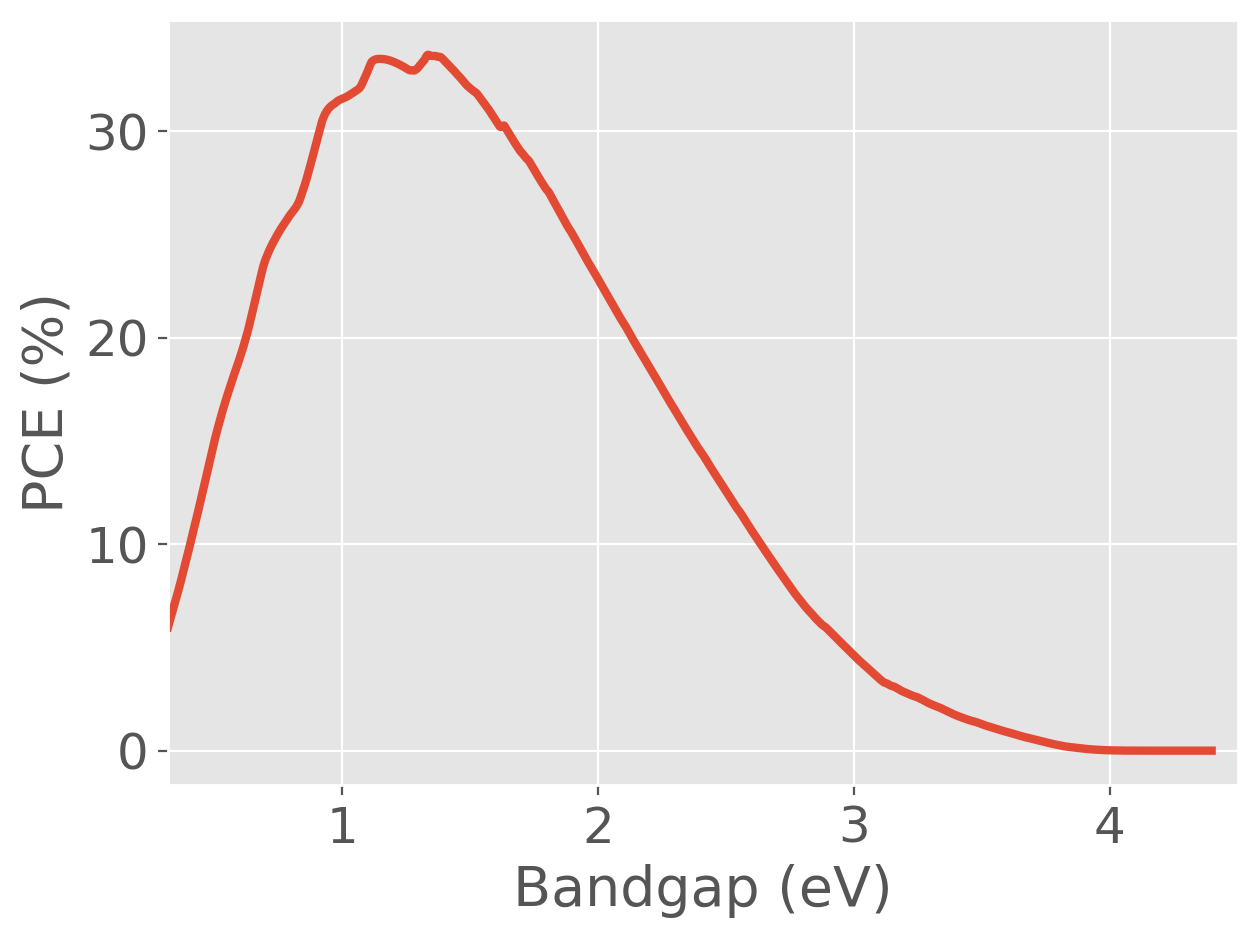

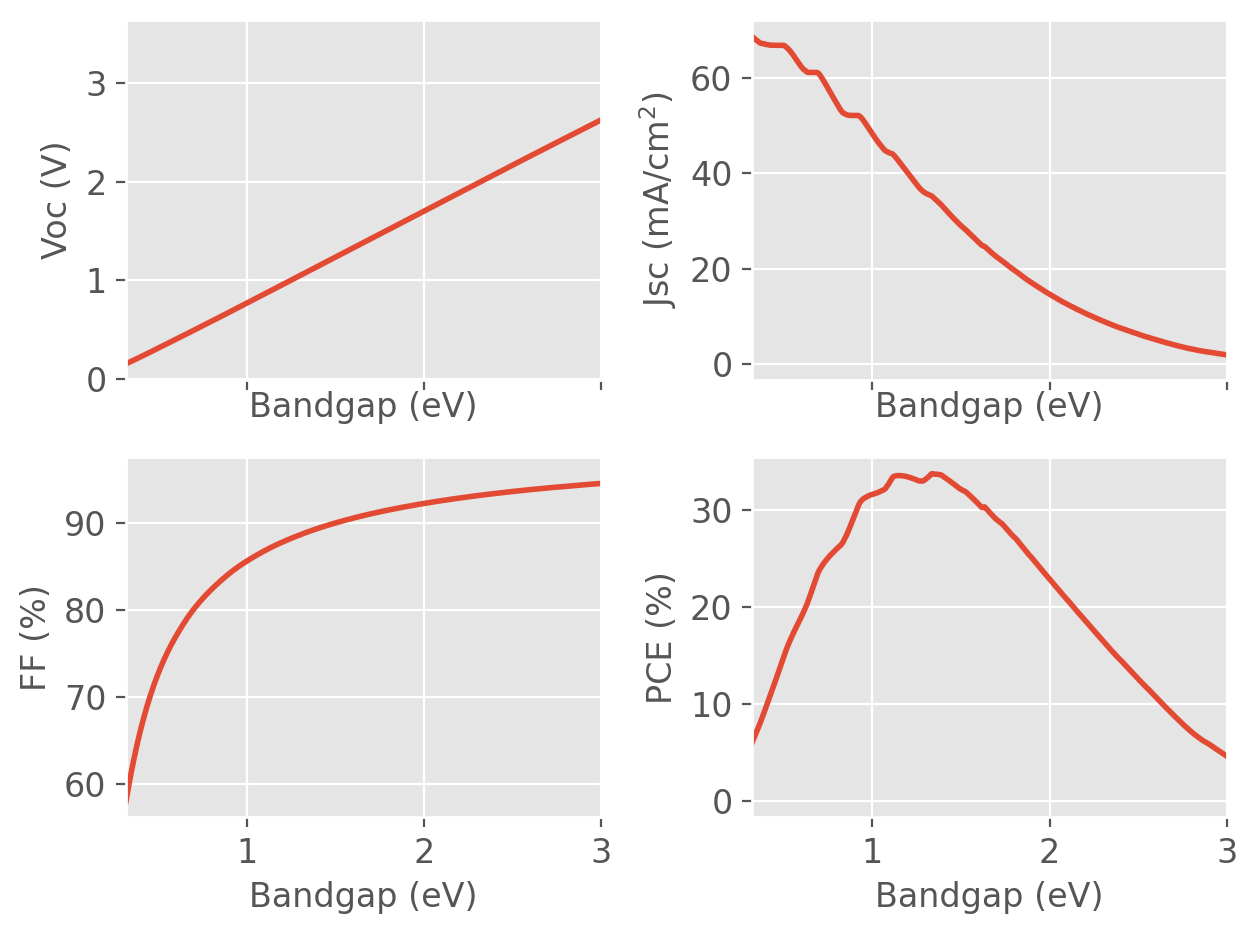

UnboundLocalError: local variable 'totE' referenced before assignment

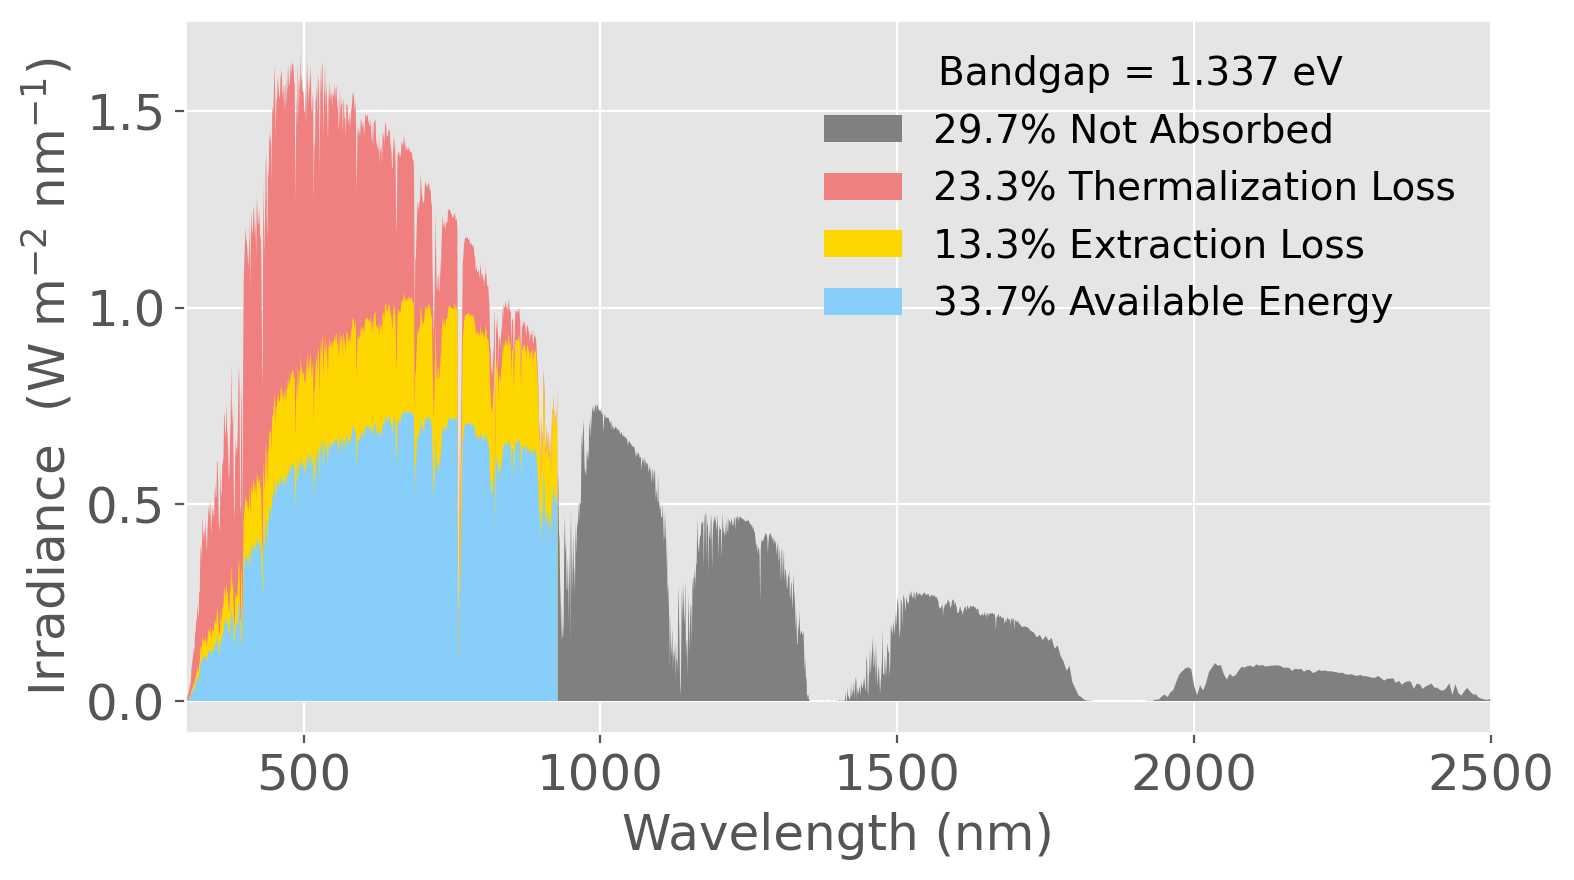

In [20]:
# -*- coding: utf-8 -*-
"""
@author: C. Marcus Chuang 2016
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.cm as pltcm
from scipy.integrate import cumtrapz
try:  # use seaborn to choose better colors
    import seaborn.apionly as sns
    with_sns = True
except:  # if you don't have seaborn
    with_sns = False
# plt.style.use(['ggplot','dark_background'])
plt.ion()
plt.style.use('ggplot')


k = 1.38064852e-23  # m^2 kg s^-2 K^-1, Boltzmi constant
h = 6.62607004e-34   # m^2 kg s^-1    , planck constant
c = 2.99792458e8     # m s^-1         , speed of light
eV = 1.6021766208e-19  # joule        , eV to joule
q = 1.6021766208e-19  # C             , elemental charge

# http://rredc.nrel.gov/solar/spectra/am1.5/
ref_solar = pd.read_csv("/Users/deniz/Documents/GitHub/Shockley-Queisser-limit/ASTMG173.csv", header=1)  # nm vs W m^-2 nm^-1
# data range: 280nm to 4000nm, 0.31eV to 4.42857 eV
# WL (nm), W*m-2*nm-1
WL, solar_per_nm = ref_solar.iloc[:, 0], ref_solar.iloc[:, 2]
E = 1240.0 / WL  # eV
# jacobian transformation, W m^-2 eV^-1
solar_per_E = solar_per_nm * (eV/1e-9) * h * c / (eV*E)**2

Es = np.arange(0.32, 4.401, 0.002)

# linear interpolation to get an equally spaced spectrum
AM15 = np.interp(Es, E[::-1], solar_per_E[::-1])  # W m^-2 eV^-1
AM15flux = AM15 / (Es*eV)  # number of photon m^-2 eV^-1 s^-1


class SQlim(object):
    def __init__(self, T=300, EQE_EL=1.0, intensity=1.0):
        """
        T: temperature in K
        EQE_EL: radiative efficiency (EL quantum yield)
        intensity: light concentration, 1.0 = one Sun, 100 mW/cm^2
        """
        try:
            T, EQE_EL, intensity = float(T), float(EQE_EL), float(intensity)
        except:
            raise ValueError("Invalid input for T, EQE_EL, or intensity")

        if T <= 0 or EQE_EL > 1.0 or EQE_EL <= 0:
            raise ValueError("Both T and EQE_EL must be greater than 0 and " +
                             "EQE_EL cannot be greater than 1.0")
        self.T = T
        self.EQE_EL = EQE_EL
        self.intensity = intensity
        self.Es = Es  # np.arange(0.32, 4.401, 0.002)
        self.calculate()
        self.WLs = np.arange(280, 4001, 1.0)
        self.AM15nm = np.interp(self.WLs, WL, solar_per_nm)

    def __repr__(self):
        s = "<SQlim:"
        conditions = []
        if self.T != 300.0:
            conditions.append("T={:.0f}K".format(self.T))
        if self.intensity != 1.0:
            conditions.append("{:.4g}-Sun".format(self.intensity))
        if self.EQE_EL != 1.0:
            conditions.append("EQE_EL={:.2E}".format(self.EQE_EL))

        if conditions:
            return s + " [" + ", ".join(conditions) + "]" + ">"
        return s + " [standard]>"

    def calculate(self, calc_current=True):
        self.J0 = self.__cal_E_J0()  # dark saturation current density
        if calc_current:
            self.Jsc = self.__cal_E_Jsc()  # shor-circuit current density
        self.Voc = self.__cal_E_Voc()  # open circuit voltage
        self.PCE = self.__cal_E_PCE()  # power conversion efficiency
        # flll factor (%)
        self.FF = self.PCE / (self.Voc*self.Jsc) * 100.0 * self.intensity
        self.paras = {"Voc": self.Voc, "Jsc": self.Jsc, "J0": self.J0,
                      "FF": self.FF, "PCE": self.PCE}
        return None

    def __cal_E_Jsc(self):
        fluxcumm = cumtrapz(AM15flux[::-1], self.Es[::-1], initial=0)
        fluxaboveE = fluxcumm[::-1] * -1 * self.intensity
        Jsc = fluxaboveE * q * 0.1  # mA/cm^2  (0.1: from A/m2 to mA/cm2)
        return Jsc

    def __cal_E_J0(self):
        '''
        Calculate and return E vs J0, the dark saturation current
        J0 = q * (integrate(phi dE) from E to infinity)  / EQE_EL
        phi is the black body radiation at T (flux vs energy)

        '''
        phi = 2 * np.pi * (((self.Es*eV)**2) * eV / ((h**3) * (c**2)) / (
                           np.exp(self.Es*eV / (k*self.T)) - 1))

        # fluxcumm = sp.integrate.cumtrapz(phi[::-1], self.Es[::-1], initial=0)
        fluxcumm = cumtrapz(phi[::-1], self.Es[::-1], initial=0)
        fluxaboveE = fluxcumm[::-1] * -1
        J0 = fluxaboveE * q * 0.1 / self.EQE_EL  # (0.1: from A/m2 to mA/cm2)
        J0[-1] = np.nan  # avoid divide by zero when calculating Voc
        return J0

    def __cal_E_Voc(self):
        '''
        Calculate and return E vs Voc
        Voc = (kT/q)*[ ln(Jsc/J0 + 1 )]
        '''
        return (k*self.T/q) * np.log((self.Jsc/self.J0) + 1)

    def __cal_E_PCE(self):
        PCE = []
        for i, E in enumerate(self.Es):
            V = np.arange(0, E, 0.001)  # can change upperbound to Voc
            J = -1 * self.Jsc[i] + self.J0[i] * (
                np.exp(q*V / (k*self.T)) - 1)
            PCE.append(-1 * np.min(J*V) / self.intensity)
        return PCE

    def simulate_JV(self, Eg, plot_dark=False, Vstep=0.001,
                    plot=True, Vmin=-0.5):
        """
        Simulate J-V curves for a solar cell at given Eg
        """

        if not self.Es[0] <= Eg <= self.Es[-1]:
            print("invalid bandgap \nvalid range: 0.32 to 4.4")
            return
        V = np.arange(Vmin, Eg, Vstep)
        paras = self.get_paras(Eg, toPrint=False)
        J0, Jsc = paras["J0"], paras["Jsc"]

        J = -1.0 * Jsc + J0 * (np.exp(q*V / (k*self.T)) - 1)
        if plot_dark:
            Jdark = J + Jsc
        mask = (J <= 200)
        if plot:
            # to do:
            # could modify the method to take xlim, ylim as inputs
            # move 'title' into the figure and add add Voc Jsc FF, PCE to it
            title = "Theoretical J-V for Eg = {:.3f} eV".format(Eg)
            # plt.figure()
            plt.plot(V[mask], J[mask], 'r')
            plt.plot([-1, Eg], [0, 0], 'k')
            plt.plot([0, 0], [-2 * Jsc, 200], 'k')
            if plot_dark:
                plt.plot(V[mask], Jdark[mask], 'b')
            plt.ylim(-1.5 * Jsc, min(40, 1.5 * Jsc))
            plt.xlim(-0.25, Eg)
            plt.xlabel("Voltage (V)", fontsize=16)
            plt.ylabel("Current density (mA/$\mathregular{cm^2}$)",
                       fontsize=16)
            plt.tick_params(labelsize=16)
            plt.title(title)
            plt.tight_layout()

        return np.vstack([V, J])  # col1: V, col2:J, photocurrent only

    def get_paras(self, Eg, toPrint=True):
        '''
        input Eg, return or print the corresponding parameters
        if toPrint == True : print the result, return nothing
        if toPrint == False: return the result as a dictionary
        '''

        if not self.Es[0] <= Eg <= self.Es[-1]:
            print("invalid bandgap \nvalid range: 0.32 to 4.4")
            return
        para = {}
        # could change these to binary search
        para["Voc"] = np.interp([Eg], self.Es, self.Voc)[0]
        para["Jsc"] = np.interp([Eg], self.Es, self.Jsc)[0]
        para["FF"] = np.interp([Eg], self.Es, self.FF)[0]
        para["PCE"] = np.interp([Eg], self.Es, self.PCE)[0]
        para["J0"] = np.interp([Eg], self.Es, self.J0)[0]

        if toPrint:  # won't return anything; print in console instead
            print
            print("Bandgap: {0:.3f} eV \n".format(Eg))
            print("J0 = {0:.3g} mA/cm^2".format(para["J0"]))
            print("Voc = {0:.4g} \t V".format(para["Voc"]))
            print("Jsc = {0:.4g} \t mA/cm^2".format(para["Jsc"]))
            print("FF  = {0:.2f} \t %".format(para["FF"]))
            print("PCE = {0:.3f} \t %".format(para["PCE"]))
            return

        return para

    def saveall(self, savename="SQ limit"):
        """
        save the data as a .csv file
        """
        result = pd.DataFrame()
        result["Bandgap (eV)"] = self.Es
        result["Voc (V)"] = self.Voc
        result["Jsc (mA/cm^2)"] = self.Jsc
        result["FF (%)"] = self.FF
        result["PCE (%)"] = self.PCE
        result["J0 (mA/cm^2)"] = self.J0
        result.to_csv(savename + ".csv", index=False)

        return result

    def plot(self, para="PCE", xlims=(0.32, 4.5)):
        """
        plot one parameters in a plot
        paras: "Voc", "Jsc", "FF", "PCE", or "J0"
        J0 will be plotted in a semi-log plot.
        """

        if para not in self.paras:
            print("Invalid input! Valid inputs are:")
            print('"Voc", "Jsc", "FF", "PCE", and "J0"')
            return
        yunits = {"Voc": "(V)", "Jsc": "(mA/$\mathregular{cm^2}$)",
                  "FF": "(%)", "J0": "(mA/$\mathregular{cm^2}$)",
                  "PCE": "(%)"}
        plt.figure(para)
        ax = plt.gca()
        ax.plot(self.Es, self.paras[para], lw=3)

        if para == "J0":
            ax.set_yscale('log')
        ax.set_ylabel(para + " " + yunits[para], size=20)
        ax.set_xlim(xlims)
        ax.set_xlabel("Bandgap (eV)", size=20)
        ax.tick_params(labelsize=18)
        plt.tight_layout()
        plt.show()

        return

    def plotall(self, xlims=(0.32, 3.0)):
        """
        plot Voc, Jsc, FF, and PCE in a figure with 4 subplots
        """

        fig, ax = plt.subplots(2, 2, sharex=True)  # figsize=(8, 8)
        axs = [(0, 0), (0, 1), (1, 0), (1, 1)]
        ys = [self.Voc, self.Jsc, self.FF, self.PCE]
        ylabel = ["Voc (V)", "Jsc (mA/$\mathregular{cm^2}$)", "FF (%)",
                  "PCE (%)"]
        for i, a in enumerate(axs):
            ax[axs[i]].plot(self.Es, ys[i], lw=2)
            ax[axs[i]].set_ylabel(ylabel[i])
            plt.setp(ax[axs[i]].get_xticklabels(), visible=True)
            ax[axs[i]].set_xlabel("Bandgap (eV)")
            ax[axs[i]].tick_params(labelsize=12)
        ax[(0, 0)].set_xlim(xlims)
        plt.tight_layout()
        plt.show()
        return

    def E_loss(self, Eg, xmin=300, xmax=2500, savefig=False):
        """
        input bandgap Eg, plot the energy loss and the available energy
        Eg :  bandgap (unit: eV)
        xmin, xmax: the limit for x-axis in the plot (unit: nm)

        return : a dictionary containing the energy losses

        """

        if Eg > 4.2 or Eg < 0.32:
            print("invalid bandgap \nvalid range: 0.32 to 4.2")
            return None
        
        xmax = max(xmax, 1240.0 / Eg)

        WLs = self.WLs
        AM15nm = self.AM15nm

        plt.figure(figsize=(8, 4.5))
        ax = plt.gca()
        # color options: darkgoldenrod, darkorange, yellow, black
        colors = {'therm': 'lightcoral', 'extract': 'gold',
                  'avail': 'LightSkyBlue', 'trans': 'grey'}

        mask = (1240.0/WLs) >= Eg
        para = self.get_paras(Eg, False)
       
        factor = para["Voc"] * para["FF"] / 100.0 / Eg
        extract = AM15nm / (1240.0/WLs) * Eg * mask
        Eavail = extract * factor
        therm = AM15nm * mask

        extractloss = extract - Eavail
        thermloss = therm - extract
        transloss = AM15nm * (1 - mask)

        ax.fill_between(WLs, 0, transloss,
                        linewidth=0, facecolor=colors['trans'])
        ax.fill_between(WLs, 0, therm,
                        linewidth=0, facecolor=colors['therm'])
        ax.fill_between(WLs, 0, extract,
                        linewidth=0, facecolor=colors['extract'])
        ax.fill_between(WLs, 0, Eavail,
                        linewidth=0, facecolor=colors['avail'])

        E_tot = np.sum(AM15nm)
        E_pct = {'trans': np.sum(transloss) / E_tot,
                 'therm': np.sum(thermloss) / E_tot,
                 'extract': np.sum(extractloss) / E_tot,
                 'avail': np.sum(Eavail) / E_tot}

        legendtitle = "Bandgap = {0:.3f} eV".format(Eg)
        legends = [plt.Rectangle((0, 0), 1, 1,
                   facecolor=colors[i], edgecolor=None)
                   for i in ['trans', 'therm', 'extract', 'avail']]

        labels = ["{:.1f}% Not Absorbed".format(100.0 * E_pct['trans']),
                  "{:.1f}% Thermalization Loss".format(100.0 * E_pct['therm']),
                  "{:.1f}% Extraction Loss".format(100.0 * E_pct['extract']),
                  "{:.1f}% Available Energy".format(100.0 * E_pct['avail'])]

        ax.plot([Eg], [0])
        ax.legend(legends, labels, frameon=False, title=legendtitle,fontsize=14, loc="upper right")
        ax.get_legend().get_title().set_fontsize(14)

        ax.set_xlim(xmin, xmax)
        ax.set_ylabel("Irradiance  (W $\mathregular{m^{-2}\ nm^{-1}}$)",
                      size=18)
        ax.set_xlabel("Wavelength (nm)", size=18)
        ax.tick_params(labelsize=18)

        plt.tight_layout()
        if savefig:
            plt.savefig("available_E.pdf", transparent=False)

        losses = pd.DataFrame()
        losses["Wavelength"] = WLs
        losses["Thermalization Loss"] = thermloss
        losses["Extraction Loss"] = extractloss
        losses["Not Absorbed"] = transloss
        losses["Available"] = Eavail

        return losses

    def available_E(self, Egs, E_MPP=True, xmin=300, xmax=2500,
                    savefig=False, legend=True, legend_totE=True, fig_out = False):
        """
        plot the theoretical maximum available energies from a series of
        solar cells with different Egs.
        This is NOT the theoretical efficiencies for "two-terminal"
        tandem cells, which would requires current matching.
        The values here are for "mechanically stacked" tandem cells.

        Egs : an array-like object of bandgaps or a float/int (one Eg)
        E_MPP : whether to scale to MPP or not
                False: Eavail = Eg * Jsc
                True : Eavail = Voc * Jsc *FF
        xmin, xmax : the limits for the x-axis
                     these would be overwritten if the values you provided do
                     not cover the range of the bandgaps in Egs
        legend : whether to show legends for the plots
        legend_totE : whether to show the total available energy in a
                       multi-junction solar cell.
                      (does nothing when there is only one value for Egs)
        """
        # 1-J : 1.337
        # 2-J : (1.63,0.96) or (1.8, 1.1)
        # 3-J : (1.82, 1.16, 0.71)

        try:  # if input Eg is a float or integer
            numEg = len(Egs)
        except:
            numEg, Egs = 1, [Egs]
        EgMax, Egmin = max(Egs), min(Egs)
        if EgMax > 4.2 or Egmin < 0.32:
            print("invalid bandgap \nvalid range: 0.32 to 4.2 eV")
            return None
        xmax = max(xmax, 1240.0 / Egmin)
        xmin = min(xmin, 1240.0 / EgMax)
        Egs = sorted(list(Egs) + [4.5])  # add a dummy 4.5 eV, a dummy Jsc 0.0

        WLs = self.WLs
        AM15nm = np.interp(WLs, WL, solar_per_nm)
        plt.figure(figsize=(8, 4.5))
        ax = plt.gca()
        # color options: darkgoldenrod, darkorange, yellow, black
        solarcolor = "gold"
        ax.fill_between(WLs, 0, AM15nm, linewidth=0.0, facecolor=solarcolor)

        factor = 1.0
        E_subcell = pd.DataFrame()
        E_subcell["WL"] = WLs
        E_subcell["Solar"] = AM15nm
        PCEsubcell, tot_E = [], 1000.0

        Jscs = [self.get_paras(E, False)["Jsc"] for E in Egs[:-1]]
        Jscs.append(0.0)

        if with_sns:
            colors = sns.color_palette("husl", len(Egs))
        else:
            cm = plt.get_cmap('gist_rainbow')  # gist_rainbow
            cNorm = pltcolors.Normalize(0, 1.2 * (numEg-1))
            scalarMap = pltcm.ScalarMappable(norm=cNorm, cmap=cm)
            colors = [scalarMap.to_rgba(i) for i in range(numEg)]

        for n, Eg in enumerate(Egs[:-1]):
            color = colors[n]
            if E_MPP:
                SQ_E = SQlim(intensity=(Jscs[n]-Jscs[n+1]) / Jscs[n],
                             T=self.T, EQE_EL=self.EQE_EL)
                para = SQ_E.get_paras(Eg, toPrint=False)
                factor = para["Voc"] * para["FF"] / 100.0 / Eg
            mask = ((1240.0/WLs) >= Eg) * (Egs[n+1] >= (1240.0/WLs))
            Eavail = factor * AM15nm / (1240.0/WLs) * Eg * mask
            E_subcell["Eg=" + str(round(Eg, 3))] = Eavail
            PCEsubcell.append(100 * np.sum(Eavail) / tot_E)
            ax.fill_between(WLs, 0, Eavail, facecolor=color, linewidth=0.0)
            # ax.fill_between(WLs, 0, Eavail, facecolor=color, linewidth=0.2)

        ax.set_xlim(xmin, xmax)
        ax.set_ylabel("Irradiance  (W $\mathregular{m^{-2}\ nm^{-1}}$)",
                      size=18)
        ax.set_xlabel("Wavelength (nm)", size=18)
        ax.tick_params(labelsize=16)

        if legend:
            legends = [plt.Rectangle((0, 0), 1, 1, facecolor=colors[i],
                       edgecolor=None) for i in range(numEg - 1, -1, -1)]

            if numEg == 1:
                labels = ["Eg={0} eV, PCE={1:.1f}%".format(Egs[0],
                          PCEsubcell[0])]

            else:
                labels = ["Cell {0}, Eg={1:.2f} eV, PCE={2:.1f}%".format(
                          numEg - i, Egs[i], PCEsubcell[i])
                          for i in range(numEg - 1, -1, -1)]

            ax.legend(legends, labels, frameon=False, loc="upper right",fontsize=14)
            

        if numEg != 1 and legend_totE:
            totE = np.nansum(PCEsubcell)  # small slice would have nan PCE
            #print("Total PCE = {0:.3f} \t %".format(totE))
            legend_title = "Total = {0:.1f} %".format(totE)
            if not ax.get_legend():
                ax.legend("", "", frameon=False, loc="upper right",title=legend_title, fontsize=14)
            else:
                ax.get_legend().set_title(legend_title)
            ax.get_legend().get_title().set_fontsize(14)
        ax.tick_params(labelsize=16)
        plt.tight_layout()
        if savefig:
            fname = "available_E_tandem"
            for E in Egs[:-1]:
                fname += "_{:.2f}".format(E)  # str(round(Es,2))
            plt.savefig(fname + ".pdf", transparent=True)
        if fig_out:
            plt.show()
        else:
            plt.close()

        return E_subcell, PCEsubcell, totE

    # some classmethods for calculating and ploting various conditions
    @classmethod
    def vary_temp(cls, T=(150, 200, 250, 300, 350),
                  xlim=(0.3, 4.0), attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print("Invalid attribute")
            return
        SQs = [SQlim(T=temp) for temp in sorted(T)]
        for SQ in SQs:
            plt.plot(Es, getattr(SQ, attr), label="T = {} K".format(SQ.T))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def vary_EQE_EL(cls, EQE_EL=(1E-6, 1E-4, 1E-2, 1),
                    xlim=[0.3, 4.0], attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print("Invalid attribute")
            return
        SQs = [SQlim(EQE_EL=EQE) for EQE in sorted(EQE_EL, reverse=True)]
        for SQ in SQs:
            strEQE = "{:0.2E}".format(SQ.EQE_EL)
            num, expo = strEQE[:4], str(int(strEQE[5:]))
            plt.plot(Es, getattr(SQ, attr),
                     label=r"$EQE_{EL} = %s \times 10^{%s}$" % (num, expo))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def vary_suns(cls, Suns=(1, 10, 100, 1000), xlim=[0.3, 4.0], attr="PCE"):
        plt.figure()
        parameters = {"PCE", "Jsc", "FF", "Voc", "J0"}
        if attr not in parameters:
            print("Invalid attribute")
            return
        SQs = [SQlim(intensity=sun) for sun in sorted(Suns, reverse=True)]
        for SQ in SQs:
            plt.plot(Es, getattr(SQ, attr),
                     label="{:4G} sun".format(SQ.intensity))
            cls.__helper_plt(xlim, attr)

        plt.show()

        return SQs

    @classmethod
    def __helper_plt(cls, xlim, attr="PCE"):
        ylabel = {"PCE": "Efficiency (%)", "Voc": "Voc (V)", "FF": "FF (%)",
                  "Jsc": "Jsc (mA/$\mathregular{cm^2}$)",
                  "J0": "J0 (mA/$\mathregular{cm^2}$)"}
        plt.xlabel("Bandgap (eV)", size=20)
        plt.ylabel(ylabel[attr], size=20)
        plt.xlim(xlim)
        plt.tick_params(labelsize=18)
        ax = plt.gca()
        ax.legend(loc='upper right', fontsize=16)
        plt.tight_layout()

        return

    @classmethod
    def Js_tandem(cls, Es):
        """
        Given several bandgap values, return the Jsc's of each subcell,
        assuming that they are mechanically stacked (No current matching)

        input: Es: array-like, bandgaps
        return : a pandas dataframe
                 where the first column is the bandgap and the second col Jsc
        """
        Es = sorted(set(Es), reverse=True)
        P = [0] + [self.get_paras(E, False)["Jsc"] for E in Es]
        df = pd.DataFrame()
        df["Bandgap (eV)"] = Es
        df["Jsc (mA/cm2)"] = [P[i] - P[i-1] for i in xrange(1, len(P))]

        return df

    # Todo:
    # def PlotElossAll(self, xlims=(0.32, 3.0)):
    #    """
    #    Plot the breakdown of E loss as a function of bandgaps
    #    in a single plot. like this:
    #    https://en.wikipedia.org/wiki/File:ShockleyQueisserBreakdown2.svg
    #    """
    #    return None

    # Todo:
    # add an option to all the "plot" methods so that one can choose
    # whether to plot Eg (eV) vs Feature or Wavelength (nm) vs Features


###################################################################

if __name__ == "__main__":
    #plt.close('all')
    SQ = SQlim()
    SQ.plot()
    SQ.plotall()
    SQ.E_loss(1.337)
    SQ.available_E(1.6)
    plt.show()

    """
    # plot Voc, Jsc, FF, PCE
    SQ.plotall() # plot Voc, Jsc, FF, PCE in one figure with 4 subplots
    SQ.plot("Voc") # plot Voc only.
    SQ.plot("PCE") # plot Jsc...other valid inputs: "Jsc", "FF", "J0"

    # get Voc, Jsc, FF, PCE for a specific bandgap
    SQ.get_paras(1.337)  # print out the values
    SQ.get_paras(1.337, toPrint=False) # get a dictionary of parameters

    # plot available energy and loss for a specific bandgap
    SQ.E_loss(1.3)

    # plot available energy for cells with many different bandgap materials
    #SQ.available_E([0.9, .6,1.5,1.2])

    ### calculate and plot JV curve
    SQ.simulate_JV(1.3, plot=True)
    """


